In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [124]:
def create_group_nest_v2(n, n_effective_groups, n_visible_groups, n_contineous_features):

    size = n
    nEg = n_effective_groups
    nVg = n_visible_groups
    
    def make_visible_split(N, m):
        base_split_size, remainder = divmod(N, m)
        splits = [base_split_size] * m
        for i in range(remainder):
            splits[i] += 1 

        result_dict = {i: splits[i] for i in range(m)}
        return splits #result_dict
    
    def make_effective_split(arr, g):
        if g <= 0:
            raise ValueError("The value of 'g' must be greater than 0")

        combined_splits = [0] * g
        groups = [[] for _ in range(g)]

        for i, num in enumerate(arr):
            group_index = i % g
            groups[group_index].append(num)

        for i in range(g):
            combined_splits[i] = sum(groups[i])
        
        groups = [item for sublist in groups for item in sublist]
        return combined_splits, groups

    cat_length = size # assign initial size to a category
    
    # generating fixed part simply y = mx + c
    X = np.random.uniform(-1, 1, size * n_contineous_features).reshape((size, n_contineous_features))
#     betas = np.ones(n_contineous_features)
    betas = np.random.randint(10, size = n_contineous_features)
    Xbeta = 0 + X @ betas # initial intercept 0
    fX = Xbeta
    data = pd.DataFrame(X)
    x_cols = ['f' + str(i) for i in range(n_contineous_features)]
    data.columns = x_cols
    e = np.random.normal(0, 1, size)
    y = fX + e
#     data['y'] = y
    ########### Create effective and visible splits ############
    
    v_splits = make_visible_split(size, nVg)
    e_splits, v_splits = make_effective_split(v_splits, nEg)
    
    data['gE'] = np.repeat(range(nEg), e_splits)
    random_intercept = np.random.randint(20, size = len(e_splits))
#     random_intercept = np.random.normal(0,1,size = len(e_splits))
    ue = np.repeat(random_intercept, e_splits)
    y = y + ue
    data['uE'] = ue
    
    ########### Visible Group split ############
    
    data['gV'] = np.repeat(range(nVg), v_splits)
    random_intercept = np.random.normal(-1,1,size = len(v_splits))
    uv = np.repeat(random_intercept, v_splits)
#     y = y+uv


    data['y'] = y
#     data['y_'] = y

    return data,e_splits, v_splits

In [100]:
df,a,b = create_group_nest_v2(1000,3,7,2)
df

,f0,f1,gE,uE,gV,y
0,-0.793912,-0.360539,0,13,0,6.815918
1,-0.492913,-0.997130,0,13,0,5.221146
2,0.997525,0.643299,0,13,0,22.568706
3,0.135161,0.247417,0,13,0,16.273752
4,0.714149,0.327569,0,13,0,18.507031
...,...,...,...,...,...,...
995,-0.551816,-0.725294,2,4,6,-3.411350
996,0.234923,-0.902520,2,4,6,0.939839
997,0.740627,-0.223985,2,4,6,7.976701
998,0.167923,-0.134340,2,4,6,4.559848


In [78]:
print("Visible Groups Splits  : ", b)
print("Effective Groups Spli`ts: ", a)

Visible Groups Splits  :  [63, 63, 63, 62, 62, 62, 63, 63, 63, 62, 62, 63, 63, 62, 62, 62]
Effective Groups Spli`ts:  [375, 313, 312]


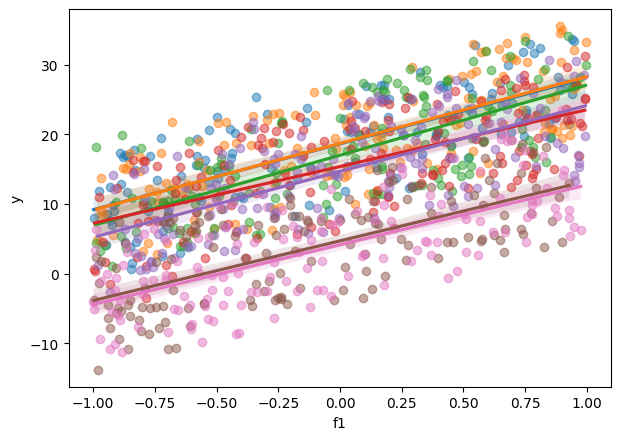

In [123]:
# df,a,b = create_group_nest_v2(1000,3,7,2)

fig_width = 7#10  # Width of the figure in inches
fig_height = 5#7.8  # Height of the figure in inches
fig_dpi = 100  # Dots per inch (resolution)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

col = "gV"

for i in np.unique(df[col]):
    sns.regplot(df[df[col] == i]['f1'], df[df[col] == i]['y'],scatter_kws={"alpha": 0.5})

In [12]:
np.random.seed(1000)
df,a,b = create_group_nest_v2(10000,120,2000,10)
df = df.drop('gE', axis=1)
# run_lr(df)
print(df)
re = run_all(df)
# df,a,b,Counter(b)


            f0        f1        f2        f3        f4        f5        f6  \
0     0.307179 -0.769986  0.900566 -0.035617  0.744949 -0.575335 -0.918581   
1    -0.585835  0.484939 -0.215692 -0.635487  0.487079 -0.860836  0.770674   
2    -0.942037  0.964055 -0.320725  0.413374 -0.276246 -0.929788  0.710117   
3     0.770186  0.808395 -0.979157 -0.850887 -0.510742 -0.733390  0.395850   
4    -0.135002 -0.963714  0.382876 -0.060619 -0.743556  0.782674  0.836407   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.692410  0.239253 -0.694626 -0.873696 -0.905074 -0.886758  0.816983   
9996  0.532394 -0.785842  0.323767 -0.954051  0.581644 -0.377920 -0.712362   
9997 -0.061983  0.856505  0.189193 -0.230749 -0.500985 -0.017588  0.218662   
9998  0.501705  0.169332 -0.346531 -0.916536 -0.818079 -0.985687 -0.312421   
9999  0.738662  0.533365  0.857480 -0.165116  0.805033 -0.739370  0.542963   

            f7        f8        f9    gV          y  
0    -0.2

(2.058240897549731, <matplotlib.collections.PathCollection at 0x2277ed394b0>)

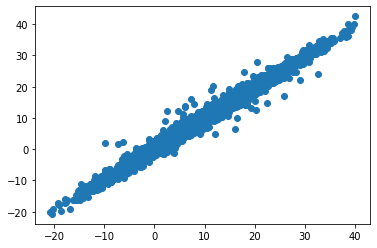

In [13]:
re[0], plt.scatter(re[2], re[3])

In [117]:
np.random.seed(50)
df,_,_ = create_group_nest_v2(1000,3,8,2)
df = df.drop('gE', axis=1)

from sklearn.preprocessing import OneHotEncoder

column_to_encode = ['gV']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[column_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(column_to_encode)).astype(int)
final_df = pd.concat([df, encoded_df], axis=1)
final_df.drop(['gV'], axis=1, inplace=True)

# g_cols = [col for col in final_df.columns if col.startswith('g') and col not in column_to_encode]
# final_df['g_cart'] = final_df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
# final_df["g_cart"] = pd.factorize(final_df['g_cart'])[0]
# final_df.drop(g_cols, axis=1, inplace=True)
final_df
run_all(final_df, use_OHE=True)

C:\Users\htals\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n_uniques:  [8, 2, 2, 2, 2, 2, 2, 2, 2]


(1.085201216765108,
 5.617610454559326,
 521    22.209383
 737    25.131974
 740    21.231695
 660     8.124842
 411    19.313836
          ...    
 506    16.673869
 342     5.835943
 485    12.725707
 711     8.828754
 133    10.665414
 Name: y, Length: 330, dtype: float64,
 array([ 22.66063682,  24.54495083,  21.08118473,   8.62303113,
         19.94868649,   4.96056854,  16.96973931,  14.18349496,
          4.01804354,   8.41455342,   9.42090967, -11.10645378,
         16.14790284,  17.97218555,  16.20246547,  10.55413145,
         -1.66350727,   2.08171523,  19.53418949,   5.64344521,
         12.59409563,   7.95073773,  -3.48566465,  21.71851245,
          9.95641591,   8.23337628,   2.15811574,   6.44639391,
          2.40712809,   1.26103932,   4.96938153,   2.5924566 ,
         28.91559402,  19.64995373,  -3.63942365,  -3.17834351,
          9.93231021,   5.85049597,  14.40455478,   3.30079687,
         -1.93100814, -12.2738961 ,   0.51492329,   4.04046208,
         -5.0483077

In [120]:
from sklearn.preprocessing import OneHotEncoder

column_to_encode = ['gV']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[column_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(column_to_encode)).astype(int)
final_df = pd.concat([df, encoded_df], axis=1)
final_df.drop(['gV'], axis=1, inplace=True)
final_df

C:\Users\htals\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,f0,f1,y,gV_0,gV_1,gV_2,gV_3,gV_4,gV_5,gV_6,gV_7
0,-0.010797,-0.543834,-5.543732,1,0,0,0,0,0,0,0
1,-0.489052,-0.207340,-5.327689,1,0,0,0,0,0,0,0
2,-0.245370,0.993148,7.807038,1,0,0,0,0,0,0,0
3,-0.183606,0.543788,5.271457,1,0,0,0,0,0,0,0
4,0.521073,-0.379981,-0.072593,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.955562,0.701636,24.515133,0,0,0,0,0,0,0,1
996,-0.815322,0.726302,13.193936,0,0,0,0,0,0,0,1
997,-0.081771,0.882865,19.473273,0,0,0,0,0,0,0,1
998,0.700591,-0.626756,11.067033,0,0,0,0,0,0,0,1


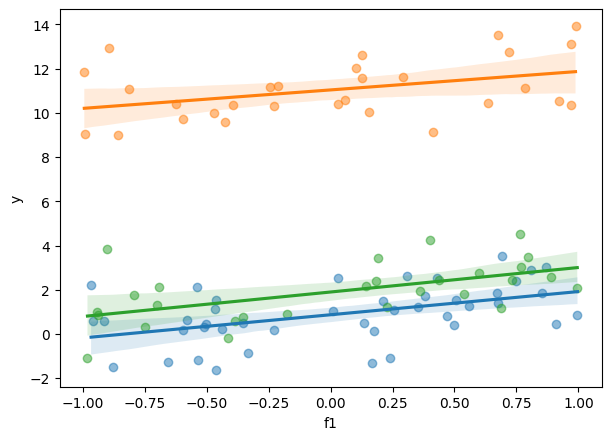

In [53]:
fig_width = 7#10  # Width of the figure in inches
fig_height = 5#7.8  # Height of the figure in inches
fig_dpi = 100  # Dots per inch (resolution)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

col = "gE"

for i in np.unique(df[col]):
    sns.regplot(df[df[col] == i]['f1'], df[df[col] == i]['y'],scatter_kws={"alpha": 0.5})

C:\Users\htals\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Intercept: 10.230006707763614

MSE: 2.501534822883626


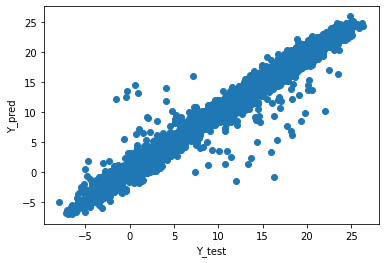

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(1000)
df,_,_= create_group_nest_v2(10000, 13,300,2)
df.drop('gE', axis=1, inplace=True)

column_to_encode = ['gV']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[column_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(column_to_encode))
final_df = pd.concat([df, encoded_df], axis=1)
final_df.drop(['gV'], axis=1, inplace=True)
df = final_df.copy()

X,y = final_df.drop('y', axis=1), final_df.y
# X,y = df.drop('y', axis=1), df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
results = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

intercept = model.intercept_
coefficients = model.coef_

print(f"Intercept: {intercept}")
# print(f"\nCoefficients: {coefficients}")
print(f"\nMSE: {mse(y_test, y_pred)}")

import scipy.stats as stats

stat, pvalue = stats.shapiro(y_pred-y_test)
print("\n\nShapiro-Wilk test:")
print("statistic:", stat)
print("p-value:", pvalue)

# Jarque-Bera test
stat, pvalue = stats.jarque_bera(y_pred-y_test)
print("Jarque-Bera test:")
print("statistic:", stat)
print("p-value:", pvalue)

plt.scatter(y_test, y_pred)
plt.ylabel('Y_pred')
plt.xlabel('Y_test')
plt.show()

In [126]:
def run_lr(df):
    
    column_to_encode = ['gV']
    encoder = OneHotEncoder(sparse=False)
    encoded_data = encoder.fit_transform(df[column_to_encode])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(column_to_encode))
    final_df = pd.concat([df, encoded_df], axis=1)
    final_df.drop(['gV'], axis=1, inplace=True)
    df = final_df.copy()

    start = time.time()
    X,y = final_df.drop('y', axis=1), final_df.y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    MSE = mse(y_test, y_pred)
    return MSE, end-start

In [125]:
def run_mixedlm(df):
    
    X, y = df.drop('y', axis=1), df['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    data_train = pd.concat([X_train, y_train], axis=1)
    
    start = time.time()
    md = sm.MixedLM.from_formula(f"y ~ {'+'.join([i for i in df.columns if i.startswith('f')])} + (1 | gV)", data_train, groups = data_train['gV'])
    mdf = md.fit()
    mlm_pred = mdf.predict(X_test)
    
    end = time.time()
    
    MSE = mse(y_test, mlm_pred)
    
    return MSE, end-start

In [230]:
f"y ~ {'+'.join([i for i in df.columns if i.startswith('f')])} + (1 | gV)"

'y ~ f0+f1+f2+f3+f4+f5+f6+f7+f8 + (1 | gV)'

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y        
No. Observations: 670     Method:             REML     
No. Groups:       5       Scale:              1.0583   
Min. group size:  123     Log-Likelihood:     -986.9752
Max. group size:  142     Converged:          Yes      
Mean group size:  134.0                                
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   18.070    2.889   6.255 0.000 12.408 23.733
f0           7.994    0.070 114.391 0.000  7.857  8.131
f1           7.918    0.067 117.762 0.000  7.786  8.050
1 | gV      -2.047    0.963  -2.125 0.034 -3.934 -0.159
Group Var   10.379    8.243                            

MSE-train:  1.0472232232588943
MSE-test:  6.968571570076317 


Shapiro-Wilk test:
statistic: 0.9740633964538574
p-value: 1.1658808034553658e-05
Jarque-Bera test:
statis

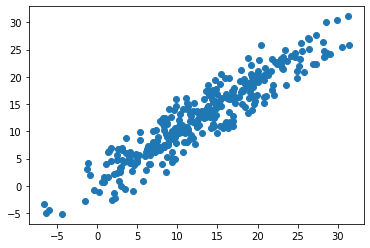

In [217]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

# np.random.seed(1000)
# df,_,_= create_group_nest_v2(1000, 2,5,2)
# df.drop('gE', axis=1, inplace=True)

X, y = df.drop('y', axis=1), df['y']
# X, y = final_df.drop('y', axis=1), final_df['y']

x_cols = [col for col in X.columns if col if not col.startswith('g')]
g_cols = [col for col in X.columns if col if col.startswith('g')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

data_train = pd.concat([X_train, y_train], axis=1)

# md = sm.OLS.from_formula(f"y ~ f0 + f1 + {'+'.join([i for i in g_cols if i!='gV'])}", data_train)

# md = sm.MixedLM.from_formula(f"y ~ f0 + f1 + {'+'.join([i for i in g_cols if i!='gV'])}", data_train,groups = data_train['gV'])

md = sm.MixedLM.from_formula(f"y ~ f0 + f1 + (1|gV)", data_train, 
                             groups = data_train['gV'])

# md = sm.MixedLM.from_formula(f"y ~ f0 + f1 + (1 | {'*'.join([i for i in g_cols if i!='gV'])})", data_train, groups = data_train['gV'])

mdf = md.fit()
print(mdf.summary())
print("MSE-train: ", mse(data_train.y, mdf.fittedvalues))
mlm_pred = mdf.predict(X_test)
print("MSE-test: ", mse(y_test, mlm_pred),"\n\n")
import scipy.stats as stats

stat, pvalue = stats.shapiro(mlm_pred-y_test)
print("Shapiro-Wilk test:")
print("statistic:", stat)
print("p-value:", pvalue)

# Jarque-Bera test
stat, pvalue = stats.jarque_bera(mlm_pred-y_test)
print("Jarque-Bera test:")
print("statistic:", stat)
print("p-value:", pvalue)

plt.scatter(y_test, mlm_pred)
plt.show()

In [158]:
results = pd.DataFrame([])
eff = list(range(2,13))
visi = list(range(2,141))

counter = Count(0).gen()

for i in eff:
    
    for j in visi:
        
        if i<j:
        
            itr = next(counter)
            print(itr,i,j)
            np.random.seed(1000)
            df,_,_ = create_group_nest_v2(1000, i,j,10)
            df = df.drop('gE', axis=1)
            
            mse_lr, lr_time = run_lr(df)
            mse_mixedlm, mixedlm_time = run_mixedlm(df)
#             mse_lmm, time_lmm, y_test, y_pred, model = run_all(df)
            
            results.at[itr, 'gE'] = i
            results.at[itr, 'gV'] = j
            
#             results.at[itr, 'mse'] = mse_lmm
#             results.at[itr, 'time'] = time_lmm
            
            results.at[itr, 'mse_lr'] = mse_lr
            results.at[itr, 'lr_time'] = lr_time
            
            results.at[itr, 'mse_mixedlm'] = mse_mixedlm
            results.at[itr, 'mixedlm_time'] = mixedlm_time


0 2 3
1 2 4
2 2 5
3 2 6
4 2 7
5 2 8
6 2 9
7 2 10
8 2 11
9 2 12
10 2 13
11 2 14
12 2 15
13 2 16
14 2 17
15 2 18
16 2 19
17 2 20
18 2 21
19 2 22
20 2 23
21 2 24
22 2 25
23 2 26
24 2 27
25 2 28
26 2 29
27 2 30
28 2 31
29 2 32
30 2 33
31 2 34
32 2 35
33 2 36
34 2 37
35 2 38
36 2 39
37 2 40
38 2 41
39 2 42
40 2 43
41 2 44
42 2 45
43 2 46
44 2 47
45 2 48
46 2 49
47 2 50
48 2 51
49 2 52
50 2 53
51 2 54
52 2 55
53 2 56
54 2 57
55 2 58
56 2 59
57 2 60
58 2 61
59 2 62
60 2 63
61 2 64
62 2 65
63 2 66
64 2 67
65 2 68
66 2 69
67 2 70
68 2 71
69 2 72
70 2 73
71 2 74
72 2 75
73 2 76
74 2 77
75 2 78
76 2 79
77 2 80
78 2 81
79 2 82
80 2 83
81 2 84
82 2 85
83 2 86
84 2 87
85 2 88
86 2 89
87 2 90
88 2 91
89 2 92
90 2 93
91 2 94
92 2 95
93 2 96
94 2 97
95 2 98
96 2 99
97 2 100
98 2 101
99 2 102
100 2 103
101 2 104
102 2 105
103 2 106
104 2 107
105 2 108
106 2 109
107 2 110
108 2 111
109 2 112
110 2 113
111 2 114
112 2 115
113 2 116
114 2 117
115 2 118
116 2 119
117 2 120
118 2 121
119 2 122
120 2 123
121 

899 8 95
900 8 96
901 8 97
902 8 98
903 8 99
904 8 100
905 8 101
906 8 102
907 8 103
908 8 104
909 8 105
910 8 106
911 8 107
912 8 108
913 8 109
914 8 110
915 8 111
916 8 112
917 8 113
918 8 114
919 8 115
920 8 116
921 8 117
922 8 118
923 8 119
924 8 120
925 8 121
926 8 122
927 8 123
928 8 124
929 8 125
930 8 126
931 8 127
932 8 128
933 8 129
934 8 130
935 8 131
936 8 132
937 8 133
938 8 134
939 8 135
940 8 136
941 8 137
942 8 138
943 8 139
944 8 140
945 9 10
946 9 11
947 9 12
948 9 13
949 9 14
950 9 15
951 9 16
952 9 17
953 9 18
954 9 19
955 9 20
956 9 21
957 9 22
958 9 23
959 9 24
960 9 25
961 9 26
962 9 27
963 9 28
964 9 29
965 9 30
966 9 31
967 9 32
968 9 33
969 9 34
970 9 35
971 9 36
972 9 37
973 9 38
974 9 39
975 9 40
976 9 41
977 9 42
978 9 43
979 9 44
980 9 45
981 9 46
982 9 47
983 9 48
984 9 49
985 9 50
986 9 51
987 9 52
988 9 53
989 9 54
990 9 55
991 9 56
992 9 57
993 9 58
994 9 59
995 9 60
996 9 61
997 9 62
998 9 63
999 9 64
1000 9 65
1001 9 66
1002 9 67
1003 9 68
1004 9 69


In [162]:
results1 = results.copy()

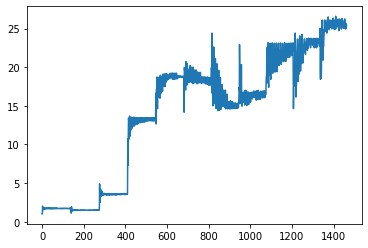

In [179]:
plt.plot(results1.mse_mixedlm)

In [155]:
results_lmmnn = results[results.gV <140]
results_lmmnn

,gE,gV,mse_lr,lr_time,mse_mixedlm,mixedlm_time
0,2.0,3.0,1.019684,0.094270,1.009233,0.318267
1,2.0,4.0,1.017122,0.029001,1.014863,0.051939
2,2.0,5.0,1.009912,0.003989,2.017409,0.042691
3,2.0,6.0,1.016772,0.002992,1.863778,0.042863
4,2.0,7.0,1.024277,0.002992,1.660580,0.049037
...,...,...,...,...,...,...
1125,4.0,135.0,1.341097,0.025040,3.537818,0.335001
1126,4.0,136.0,1.261787,0.025096,3.640697,0.337584
1127,4.0,137.0,1.303939,0.025256,3.592317,0.339202
1128,4.0,138.0,1.261453,0.024613,3.585676,0.339102


In [128]:
results1.to_csv("result_new.csv", index=False)

NameError: name 'results1' is not defined

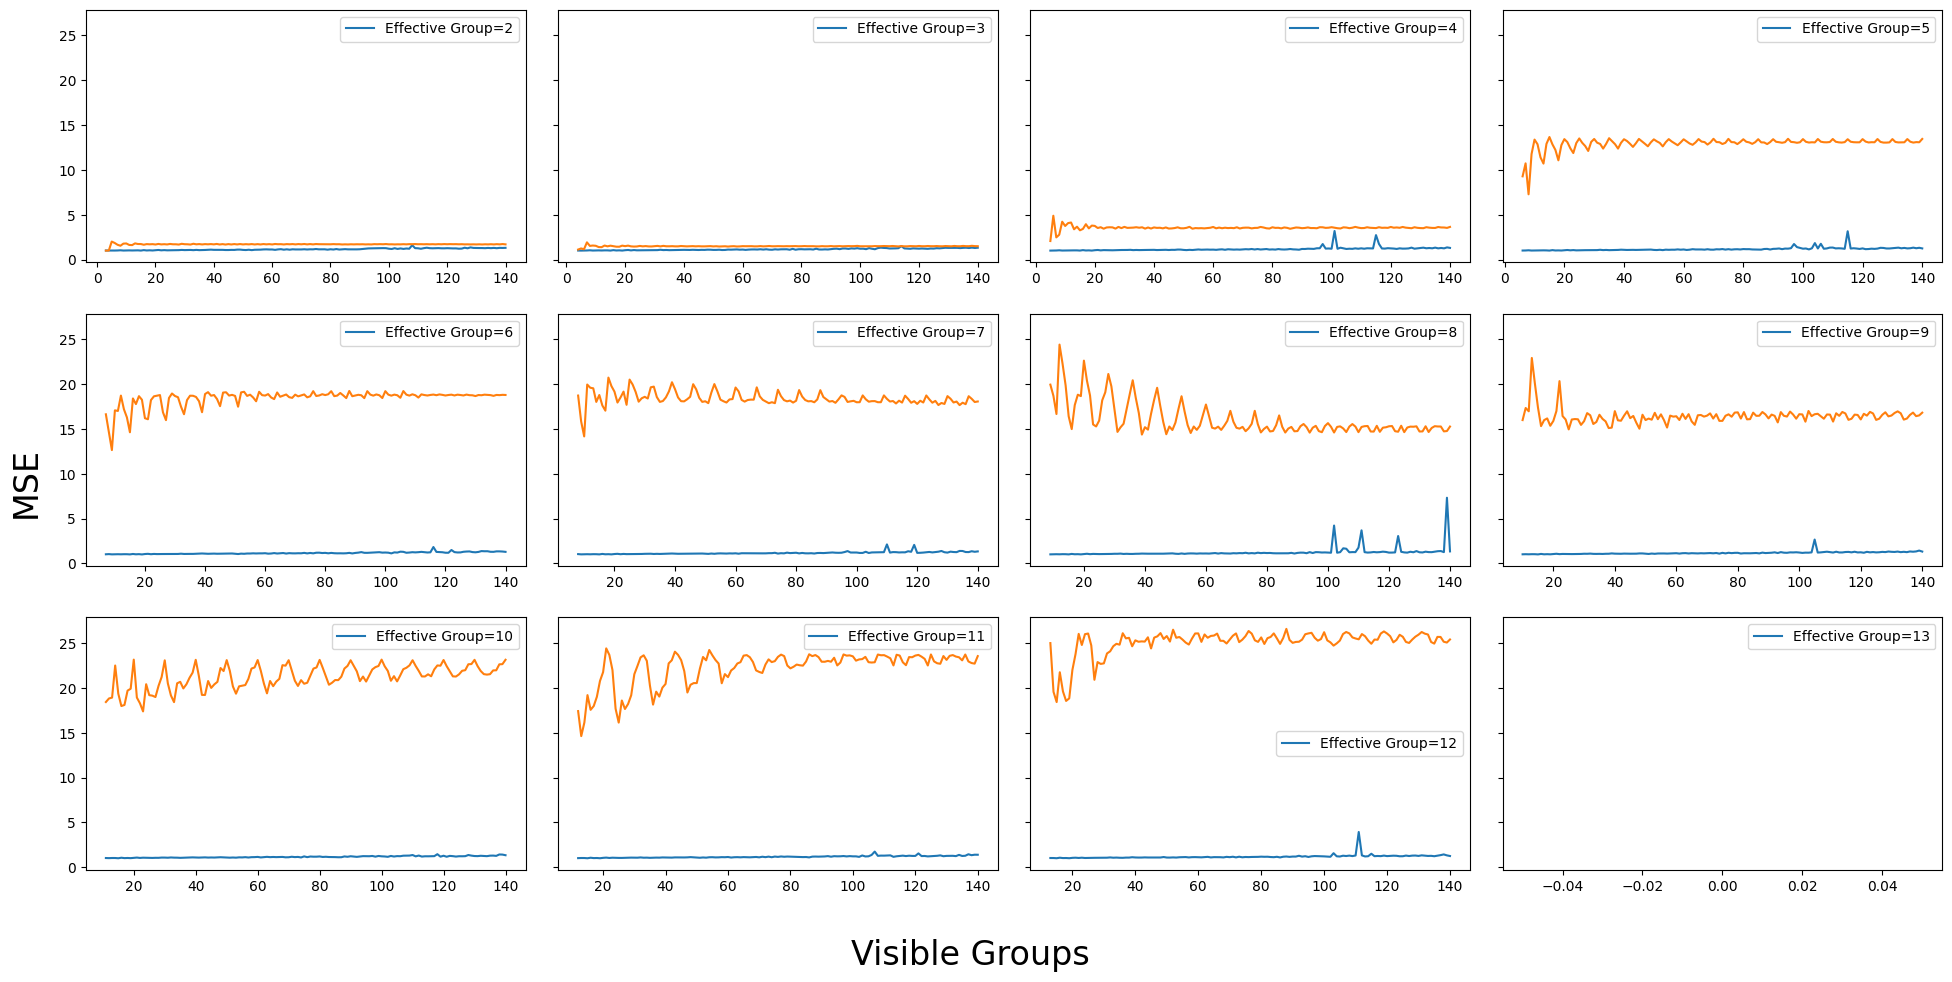

In [183]:
from matplotlib.gridspec import GridSpec

# results1 = result_lr_mixedlm.copy()
# results1 = results_lmmnn.copy()

fig, ax = plt.subplots(3,4, figsize=(20, 10), dpi=100, sharey=True, sharex = False)
no = Count(2).gen()
gs = GridSpec(4, 4, figure=fig, wspace=0.0, hspace=0.0)
for itr1 in [0,1,2]:
    for itr2 in [0,1,2,3]:
#         if itr1 == 2 and itr2>1:
#             break
        number = next(no)
        data = results1[results1['gE'] == number]
        ax[itr1,itr2].plot(data.gV, data.mse_lr)
        ax[itr1,itr2].plot(data.gV, data.mse_mixedlm)
#         ax[itr1,itr2].set_title("Effective Group="+str(number))
#         ax[itr1,itr2].set_ylim(0, int(max(results1.mse_lr)))
        ax[itr1,itr2].legend(labels=["Effective Group="+str(number)], loc='best')

# ax[2,2].axis('off')
# ax[2,3].axis('off')

fig.supxlabel('Visible Groups', fontsize=24)
fig.supylabel('MSE', fontsize=24)
fig.tight_layout(pad = 2)

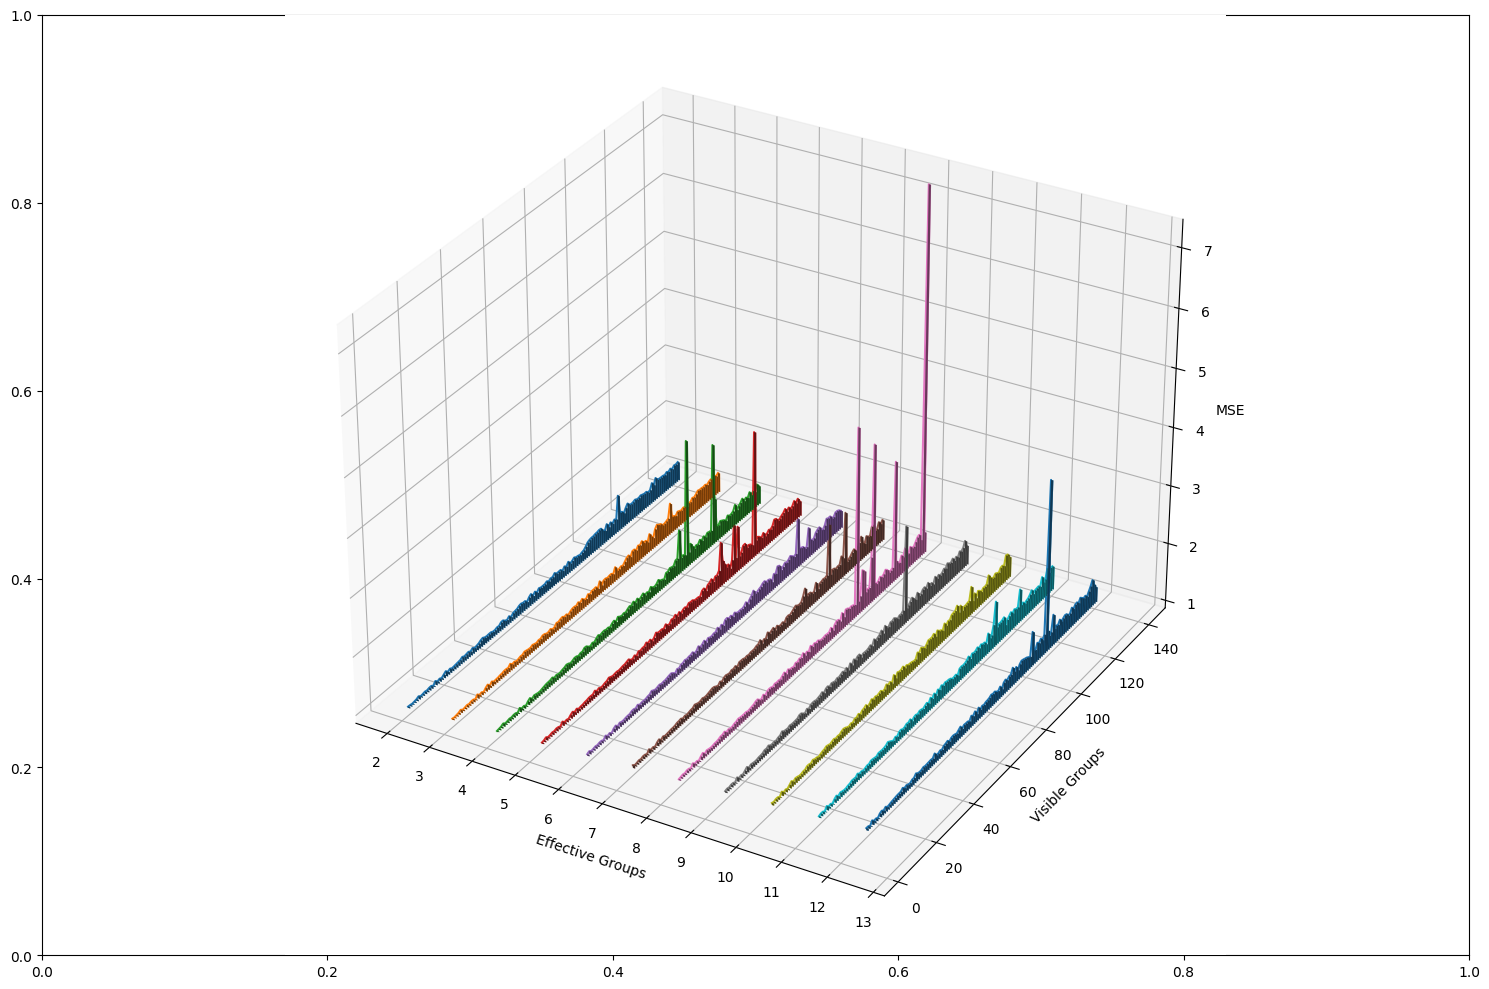

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig_width = 15  # Width of the figure in inches
fig_height = 10  # Height of the figure in inches
fig_dpi = 100  # Dots per inch (resolution)

# results1 = result_lr_mixedlm.copy()
# results1 = results_lmmnn.copy()

# Create a figure and axis
fig = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

ax = plt.axes(projection='3d')

# fig = plt.figure(figsize=(8, 5),dpi=100)
# ax = fig.add_subplot(projection='3d')

for i in np.unique(results1.gE):
    
    data = results1[results1['gE'] == i]
    g1 = data['gE']
    g2 = data['gV']
    error = data['mse_lr']
#     error = data['mixedlm_time']
    
    ax.bar3d(g1, g2, error, dx=0.05, dy=0.05, dz=(1-error),cmap='inferno', alpha = 0.9)
#     ax.plot_trisurf(g1, g2, error, cmap='viridis', linewidth=0.02)
    ax.plot3D(g1, g2, error, linewidth=1.5)
#     ax.scatter3D(g1, g2, error, linewidth = 3)


# Add labels and a colorbar
# ax.set_title('Random Intercept on LMMNN')
ax.set_ylabel('Visible Groups')
ax.set_xlabel('Effective Groups')
ax.set_zlabel('MSE')
ax.set_xticks([2,3,4,5,6,7,8,9,10,11,12,13])

# Show the plot
plt.tight_layout()
plt.show()


In [345]:
results_lmmnn.tail()

,gE,gV,mse,time
3517,13.0,296.0,7.516842,1.513500
3518,13.0,297.0,7.568199,1.627028
3519,13.0,298.0,8.217967,1.604841
3520,13.0,299.0,7.584651,1.587525
3521,13.0,300.0,7.828256,1.586423


In [ ]:
x = results['gE']  # Sample values for g1
y = results['gV']  # Sample values for g2
Z = results['mse']

X, Y = np.meshgrid(x, y)
# Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [132]:
from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_lmm, reg_nn_embed, reg_nn_rnn
from lmmnn.simulation import Count
from lmmnn.utils import *
import gc
import time
import tensorflow.keras.backend as K

def run_all(df, use_OHE = False):
    
    if use_OHE == True:
        g_cols = [col for col in df.columns if col if col.startswith('g')]
        df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
        df["g_cart"] = pd.factorize(df['g_cart'])[0]
        
        df.rename(columns={'g_cart': 'z0'}, inplace=True)
        df.rename(columns={f'{col}': f'z{i+1}' for i, col in enumerate(g_cols)}, inplace=True)
    else:
        df.rename(columns={'g_cart': 'z0'}, inplace=True)
        df.rename(columns={'gV': 'z0', 'gE': 'z1'}, inplace=True)

    z_cols = sorted([col for col in df.columns if col.startswith('z')], key=lambda x: int(x[1:]))

    # mode = 'slopes'
    mode = 'intercepts'
    n_cats = [len(df[i].unique()) for i in z_cols]
    qs = n_cats
    batch_size = 100
    epochs = 500
    patience = 10
    n_sig2bs = len(n_cats)
    n_sig2bs_spatial = 0
    est_cors = []
    n_neurons = [50,25,12,6]
    activation = 'linear'
    dropout = []
    spatial_embedded_neurons = []
    dist_matrix = None
    q_spatial = None

    print('n_uniques: ', n_cats)

    X, y = df.drop('y', axis=1), df['y']
    x_cols = [col for col in X.columns if col if not col.startswith('z')]#['z0','z1','z2','z3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
    X_test[x_cols]  = scaler.transform(X_test[x_cols])

    def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=batch_size, epochs=epochs, patience=patience, reg_type='lmm', verbose=False):

        start = time.time()
        if reg_type == 'lmm':
            model_fitted, history, y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, q_spatial, x_cols, batch, epochs, patience,
                                                     n_neurons, dropout, activation,
                                                     mode=mode, n_sig2bs=n_sig2bs, n_sig2bs_spatial=n_sig2bs_spatial,
                                                     est_cors=est_cors, dist_matrix=dist_matrix,
                                                     spatial_embed_neurons=spatial_embedded_neurons, verbose=verbose, log_params=False)
        else:
            raise ValueError(reg_type + 'is an unknown reg_type')
        end = time.time()
        gc.collect()
        K.clear_session()
        mse = np.mean((y_pred - y_test)**2)
        return mse, sigmas, n_epochs, end - start, y_pred, model_fitted

    mse_lmm, sigmas, n_epochs_lmm, time_lmm,y_pred, model= reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', verbose=False)

    return mse_lmm, time_lmm, y_test, y_pred, model 